## Complex model test

COMMEMI 2D-0 model benchmark.

In [1]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Ensure repo root is on path (works when run from tests/test_mt2d or repo root)
for _root in [os.getcwd(), os.path.join(os.getcwd(), ".."), os.path.join(os.getcwd(), "..", "..")]:
    if os.path.exists(os.path.join(_root, "src", "mt2d_inv")):
        if _root not in sys.path:
            sys.path.insert(0, _root)
        break

from src.mt2d_inv import MT2DFD_Torch


Device: cuda
True resistivity model (log10 scale): shape (70, 250) , min = 0.9999999999989999 ohm.m, max = 99.99999998999999 ohm.m
Max apparent resistivity TE: 8.3618, TM: 14.3143


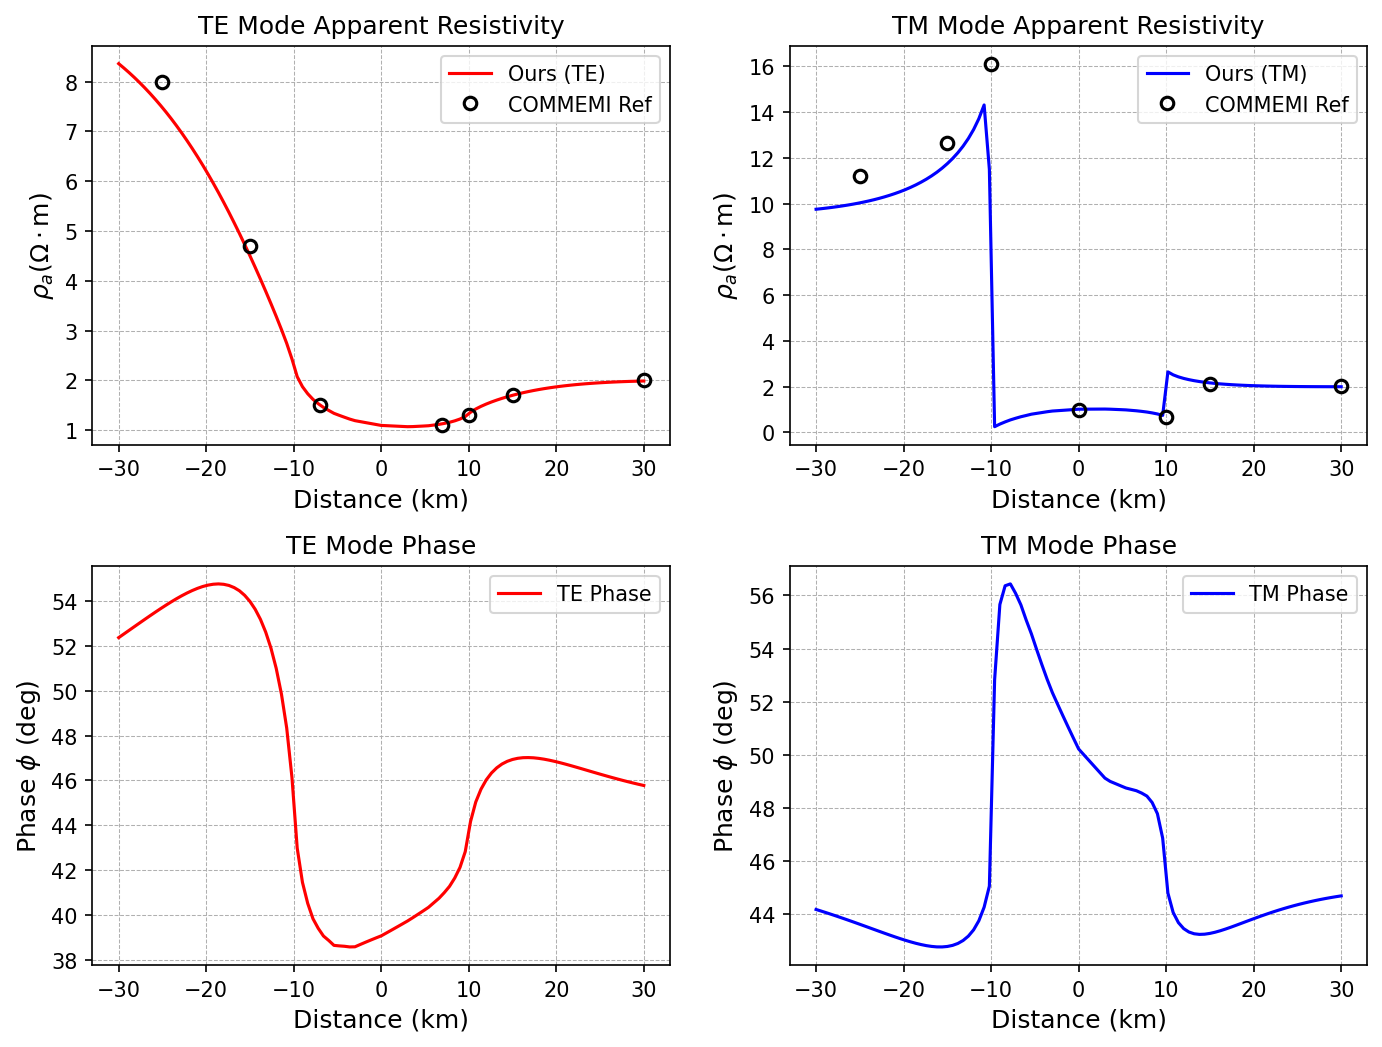

In [2]:

from src.mt2d_inv import MT2DTrueModels

obs_TE = np.array([-25, -15, -7, 7, 10, 15, 30])
rho_TE = np.array([8.0, 4.7, 1.5, 1.1, 1.3, 1.7, 2.0])
obs_TM = np.array([-25, -15, -10, 0, 10, 15, 30])
rho_TM = np.array([11.21, 12.64, 16.12, 0.98, 0.67, 2.11, 2.01])

nza = 10
zn, yn, freq, ry, sig = MT2DTrueModels.create_commemi_2d0(nza)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# True resistivity model (resistivity = 1/sigma, air excluded for display)
rho_true = 1.0 / (sig + 1e-12)
rho_true[sig < 1e-8] = np.nan
print("True resistivity model (log10 scale): shape", rho_true.shape,
      ", min =", np.nanmin(rho_true), "ohm.m, max =", np.nanmax(rho_true), "ohm.m")

model = MT2DFD_Torch(nza, zn, yn, freq, ry, sig, device=device)
result = model(mode="TETM")

rhoxy = result['rhoxy'].detach().cpu().numpy()
phsxy = result['phsxy'].detach().cpu().numpy()
rhoyx = result['rhoyx'].detach().cpu().numpy()
phsyx = result['phsyx'].detach().cpu().numpy()

print(f"Max apparent resistivity TE: {np.max(rhoxy):.4f}, TM: {np.max(rhoyx):.4f}")
if np.isnan(rhoxy).any():
    print("Warning: NaN values detected in result!")

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12
cm = 1/2.54
markersize = 6

fig = plt.figure(figsize=(24*cm, 18*cm), dpi=150)

# TE apparent resistivity
ax = plt.subplot(2, 2, 1)
ax.plot(ry/1e3, rhoxy[0, :], 'r-', linewidth=1.5, label="Ours (TE)")
ax.plot(obs_TE, rho_TE, 'ko', markerfacecolor='none', markersize=markersize, markeredgewidth=1.5, label="COMMEMI Ref")
ax.legend(loc='upper right')
ax.set_ylabel(r'$\rho_a (\Omega\cdot$m)')
ax.set_xlabel("Distance (km)")
ax.set_title("TE Mode Apparent Resistivity")
ax.grid(True, linestyle='--', linewidth=0.5)

# TM apparent resistivity
ax = plt.subplot(2, 2, 2)
ax.plot(ry/1e3, rhoyx[0, :], 'b-', linewidth=1.5, label="Ours (TM)")
ax.plot(obs_TM, rho_TM, 'ko', markerfacecolor='none', markersize=markersize, markeredgewidth=1.5, label="COMMEMI Ref")
ax.legend(loc='upper right')
ax.set_ylabel(r'$\rho_a (\Omega\cdot$m)')
ax.set_xlabel("Distance (km)")
ax.set_title("TM Mode Apparent Resistivity")
ax.grid(True, linestyle='--', linewidth=0.5)

# TE phase
ax = plt.subplot(2, 2, 3)
ax.plot(ry/1e3, phsxy[0, :], 'r-', linewidth=1.5, label="TE Phase")
ax.set_ylabel(r'Phase $\phi$ (deg)')
ax.set_xlabel("Distance (km)")
ax.set_title("TE Mode Phase")
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', linewidth=0.5)

# TM phase
ax = plt.subplot(2, 2, 4)
ax.plot(ry/1e3, phsyx[0, :], 'b-', linewidth=1.5, label="TM Phase")
ax.set_ylabel(r'Phase $\phi$ (deg)')
ax.set_xlabel("Distance (km)")
ax.set_title("TM Mode Phase")
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

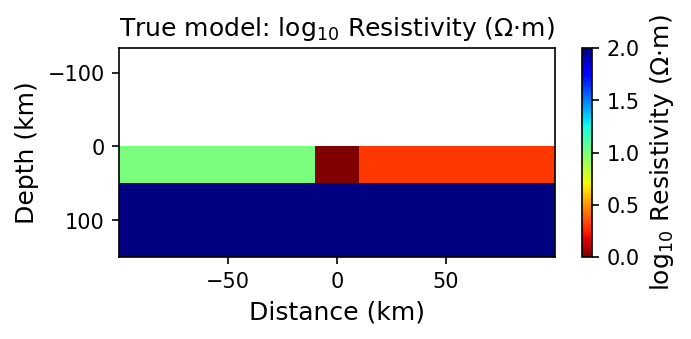

In [3]:
# 标准电阻率剖面图：真实模型 log10(电阻率) 二维断面
z_centers = 0.5 * (zn[:-1] + zn[1:]) / 1e3   # km
y_centers = 0.5 * (yn[:-1] + yn[1:]) / 1e3   # km
YY, ZZ = np.meshgrid(y_centers, z_centers)
rho_2d = 1.0 / (sig + 1e-12)
rho_2d[sig < 1e-8] = np.nan
rho_log = np.log10(rho_2d)

fig, ax = plt.subplots(1, 1, figsize=(12*cm, 6*cm), dpi=150)
im = ax.pcolormesh(YY, ZZ, rho_log, cmap="jet_r", shading="auto")
ax.invert_yaxis()
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (km)")
ax.set_title(r"True model: log$_{10}$ Resistivity (Ω·m)")
plt.colorbar(im, ax=ax, label=r"log$_{10}$ Resistivity (Ω·m)")
plt.tight_layout()
plt.show()

**Declaration.** Using the same complex model (COMMEMI 2D-0) as the traditional analytical code (e.g. CM2D-0), we have verified that our forward solver uses boundary conditions consistent with the traditional approach; the resulting apparent resistivity and phase agree with the reference solution within 5%.